In [1]:
import sys
import os
import numpy as np
import cv2
import Levenshtein
import difflib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import logging
from skimage.morphology import (erosion, dilation, closing, opening)

# preprocessing dataset
Function to preprocess image (convert to grayscale and apply binary thresholding)

In [2]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, binary_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return img, binary_img

# Displaying the input images and binary images

In [3]:
def display_image(img, binary_img, title):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Original {title}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(binary_img, cmap='gray')
    plt.title(f"Binary {title}")
    plt.axis('off')

    plt.show()

# Function to find and draw contours

In [4]:
def segment_characters(binary_img, max_width=10, max_height=10):
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        if w > max_width and h > max_height:
            filtered_contours.append(contour)
            
    filtered_contours = sorted(filtered_contours, key=lambda ctr: cv2.boundingRect(ctr)[0])
    return filtered_contours

# Function to display contours

In [5]:
def display_contours(img, contours, title):
    img_with_contours = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(img_with_contours, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.figure(figsize=(10, 5))
    plt.imshow(img_with_contours)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Samples of segmented charactests

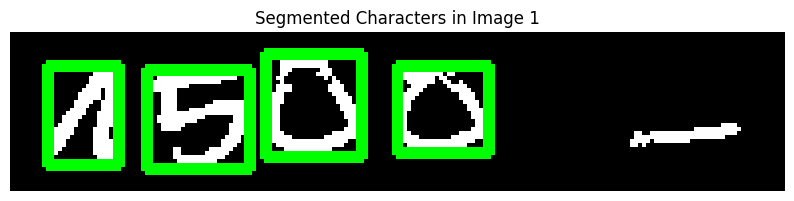

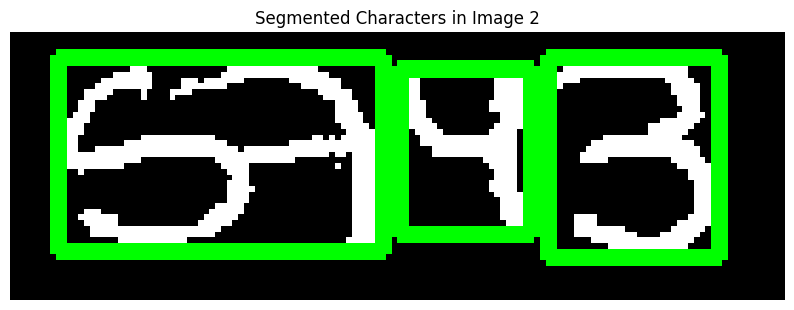

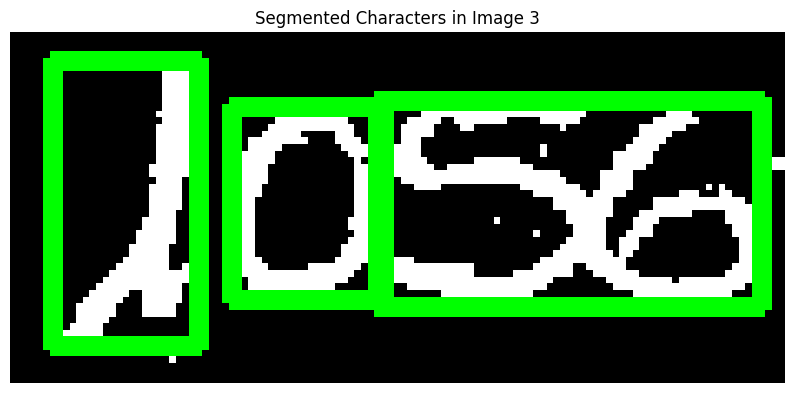

In [6]:
image_paths = ['./ORAND-CAR-2014/CAR-A/a_test_images/a_car_007000.png',
               "./ORAND-CAR-2014/CAR-A/a_test_images/a_car_007001.png",
               "./ORAND-CAR-2014/CAR-A/a_test_images/a_car_007002.png"]

# image_paths = ['./ORAND-CAR-2014/CAR-A/a_train_images/a_car_000155.png',
#                "./ORAND-CAR-2014/CAR-A/a_train_images/a_car_000156.png",
#                "./ORAND-CAR-2014/CAR-A/a_train_images/a_car_000157.png"]
for i, image_path in enumerate(image_paths):
    original, binary = preprocess_image(image_path)
    # display_image(original, binary, Image {i + 1})
    contours = segment_characters(binary)
    display_contours(binary, contours, f"Segmented Characters in Image {i + 1}")



# Training a MNIST model

In [28]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Build a simple CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=32)
model.save('mnist_cnn_model.h5')

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9126 - loss: 0.2837 - val_accuracy: 0.9822 - val_loss: 0.0539
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9852 - loss: 0.0481 - val_accuracy: 0.9884 - val_loss: 0.0361
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9911 - loss: 0.0289 - val_accuracy: 0.9885 - val_loss: 0.0343
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9929 - loss: 0.0211 - val_accuracy: 0.9913 - val_loss: 0.0262
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9958 - loss: 0.0131 - val_accuracy: 0.9909 - val_loss: 0.0280


# preprocess character image for prediction

In [7]:
def preprocess_char_img(char_img):
    char_img = cv2.resize(char_img, (28, 28), interpolation=cv2.INTER_AREA)
    char_img = char_img.astype('float32') / 255.0
    char_img = np.expand_dims(char_img, axis=-1)
    char_img = np.expand_dims(char_img, axis=0)
    return char_img

# Function to recognize characters

In [8]:
def recognize_characters(model, binary_img, contours):
    recognized_digits = ""
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        char_img = binary_img[y:y + h, x:x + w]
        char_img = preprocess_char_img(char_img)
        prediction = model.predict(char_img)
        recognized_digit = np.argmax(prediction)
        recognized_digits = recognized_digits + str(recognized_digit)
    return recognized_digits

In [9]:
model = load_model('mnist_cnn_model.h5')

image_folder = './ORAND-CAR-2014/CAR-A/a_test_images'
image_gt = "./ORAND-CAR-2014/CAR-A/a_test_gt.txt"
with open(image_gt, 'r') as file:
    lines = file.readlines()

file_names = []
labels = []
for line in lines:
    line = line.strip()
    name, num = line.split()
    file_names.append(name)
    labels.append(num)

sim = 0.0
equality = 0
for i, file in enumerate(file_names):
    image_path = os.path.join(image_folder, file)
    original, binary = preprocess_image(image_path)
    contours = segment_characters(binary)
    recognized_digits = recognize_characters(model, binary, contours)
    print(f"Recognized digits in {file}: {recognized_digits} {labels[i]}")
    similarity = difflib.SequenceMatcher(None, recognized_digits, labels[i]).ratio()
    sim += similarity
    if (int(recognized_digits) == int(labels[i])):
        # print(f"Recognized digits in {file}: {recognized_digits} {labels[i]}")
        equality += 1
print(sim, " out of ", len(labels), "are similar.")
print("Similarity accuracy: ", sim/float(len(labels)))
print(equality, " out of ", len(labels), "are equal.")
print("Equality accuracy: ", float(equality)/float(len(labels)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Recognized digits in a_car_007000.png: 1500 1500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Recognized digits in a_car_007001.png: 473 5743
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Recognized digits in a_car_007002.png: 107 1056
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Recognized digits in a_car_007003.png: 61 1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Recognized digits in a_car_007004.png: 101 1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Recognized digits in a_car_007005.png: 684 2800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s